In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse.linalg as spla

np.set_printoptions(linewidth=130)

In [2]:
from fsmfuncs import *
from gridfuncs import *

Numerical grid for the fluid

In [3]:
x = np.linspace(0, 1, 65)
y = np.linspace(0, 1, 65)
n, m = len(y)-1, len(x)-1

dy, dx = np.diff(y), np.diff(x)
dxmin = min(np.min(dx), np.min(dy))

yp, xp = 0.5*(y[1:] + y[:-1]), 0.5*(x[1:] + x[:-1])
dyp, dxp = np.diff(yp), np.diff(xp)
p = np.zeros( (n, m) )

yu, xu = yp, x[1:-1]
u = np.zeros( (n, m-1) )

yv, xv = y[1:-1], xp
v = np.zeros( (n-1, m) )

Plot grid and immersed boundary

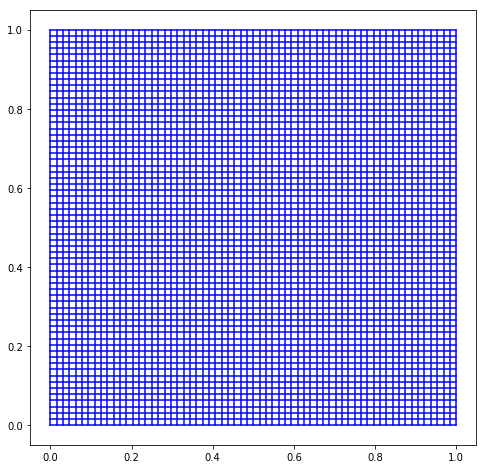

In [4]:
plt.figure(figsize=(8,8))
X, Y = np.meshgrid(x, y)
plt.plot(X, Y, 'b-');
plt.plot(X.T, Y.T, 'b-');

In [5]:
uS, uN = np.zeros(m-1), np.ones(m-1)
uE, uW = np.zeros(n), np.zeros(n)

vS, vN = np.zeros(m), np.zeros(m)
vE, vW = np.zeros(n-1), np.zeros(n-1)

u[:,:]=0
v[:,:]=0

Build matrices (I)

In [6]:
G, DuW, DuE, DvS, DvN = gradient(dxp, dyp)
R, iR = weight (dx, dy)
Mh, iMh = mass_hat (dxp, dyp)
Lh, Lux0, Lux1, Luy0, Luy1, Lvx0, Lvx1, Lvy0, Lvy1 = laplacian_hat(dx, dy, dxp, dyp)

L = Mh.dot(Lh.dot(iR))

M = Mh.dot(iR)
iM = R.dot(iMh)

iML = iM.dot(L)
Q = G

Build matrices (II)

In [7]:
iRe = 1/1000.0
dt = 0.8 * min(dxmin**2/iRe, dxmin)
print(dxmin**2/iRe, dxmin)

0.244140625 0.015625


In [8]:
A = (M/dt - 0.5*iRe*L).tocsc()
B = (M/dt + 0.5*iRe*L).tocsr()

iA = spla.factorized(A)

BN = dt*iM + (0.5*iRe)*dt**2*iML.dot(iM) + (0.5*iRe)**2*dt**3*iML.dot(iML.dot(iM))
QTBNQ = Q.T.dot(BN.dot(Q)).tocsc()
iQTBNQ = spla.factorized(QTBNQ)

In [9]:
q = R.dot(np.concatenate([u.ravel(), v.ravel()]))
qast = q.copy()

Num1, Nvm1 = advection_hat(dx, dy, dxp, dyp, iR.dot(q),  uS, uN, uW, uE, vS, vN, vW, vE)
Nu, Nv = Num1, Nvm1

In [10]:
nt = int(100/dt)
print("Performing", nt, "steps")

residuals = np.zeros(nt)

for k in range(nt):    
    ru = iRe*(Lux0.dot(uW) + Lux1.dot(uE) + Luy0.dot(uS) + Luy1.dot(uN)) - 1.5*Nu + 0.5*Num1
    rv = iRe*(Lvx0.dot(vW) + Lvx1.dot(vE) + Lvy0.dot(vS) + Lvy1.dot(vN)) - 1.5*Nv + 0.5*Nvm1
    
    bc1 = Mh.dot(np.concatenate([ru, rv]))
    r1 = B.dot(q.ravel()) + bc1

    qast = iA(r1)
    
    bc2 =  (DuW.dot(uW*dxp[0]) + DuE.dot(uE*dxp[-1]) + DvS.dot(vS*dyp[0]) + DvN.dot(vN*dyp[-1]))

    λ = iQTBNQ(Q.T.dot(qast) - bc2)

    qp1 = qast - BN.dot(Q.dot(λ))
    
    residuals[k] = la.norm(qp1-q)/(dt*la.norm(qp1))
    
    if k%100==0:
        print(k, k*dt, residuals[k])
    
    q = qp1

    Num1, Nvm1 = Nu, Nv
    Nu, Nv = advection_hat(dx, dy, dxp, dyp, iR.dot(q), uS, uN, uW, uE, vS, vN, vW, vE)

iRq = iR.dot(q)
u, v = iRq[:n*(m-1)].reshape((n, m-1)), iRq[n*(m-1):].reshape((n-1, m))
p = λ[:n*m].reshape((n,m))

Performing 8000 steps
0 0.0 80.0
100 1.25 0.51602943209
200 2.5 0.372591476009
300 3.75 0.275618133708
400 5.0 0.206638695294
500 6.25 0.158695220826
600 7.5 0.124626253267
700 8.75 0.0997259949562
800 10.0 0.0808470101178
900 11.25 0.0659979783751
1000 12.5 0.0540538858114
1100 13.75 0.0443908909138
1200 15.0 0.0365385261261
1300 16.25 0.0300318370343
1400 17.5 0.0244802571011
1500 18.75 0.0196693503715
1600 20.0 0.0155535938056
1700 21.25 0.0121544450945
1800 22.5 0.00945583133958
1900 23.75 0.00736418390004
2000 25.0 0.0057404807925
2100 26.25 0.00446325990961
2200 27.5 0.0034595841326
2300 28.75 0.00268793586259
2400 30.0 0.00210963985805
2500 31.25 0.00167685243298
2600 32.5 0.00134329884529
2700 33.75 0.00107990383033
2800 35.0 0.000873755034411
2900 36.25 0.000717228679669
3000 37.5 0.000600007626352
3100 38.75 0.000509271086139
3200 40.0 0.000435737592781
3300 41.25 0.00037553342611
3400 42.5 0.000327269242143
3500 43.75 0.000289137748159
3600 45.0 0.000258080782303
3700 46.25 

Display solution

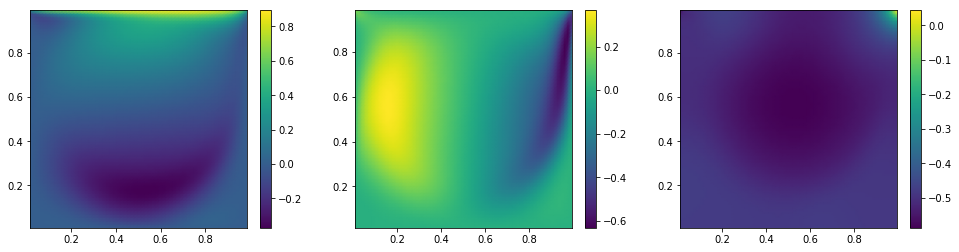

In [11]:
plt.figure(figsize=(5.5*3,4))
plt.subplot(1,3,1)
plt.pcolormesh(xu, yu, u, shading='gouraud')
plt.xlim(xu[0], xu[-1])
plt.ylim(yu[0], yu[-1])
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(xv, yv, v, shading='gouraud')
plt.xlim(xv[0], xv[-1])
plt.ylim(yv[0], yv[-1])
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(xp, yp, p, shading='gouraud')
plt.xlim(xp[0], xp[-1])
plt.ylim(yp[0], yp[-1])
plt.colorbar()

Comparison with results from Ghia et al. (1982)

In [12]:
ghia = np.loadtxt("LidDrivenCavityRe1000_Ghia.csv", skiprows=1)

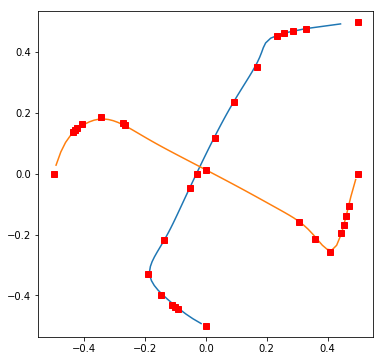

In [13]:
plt.figure(figsize=(6,6))
plt.plot(0.5*u[:,(m-1)//2], yu-0.5);
plt.plot(0.5*ghia[:,1], ghia[:,0]-0.5,'sr')

plt.plot(xv-0.5, 0.5*v[(n-1)//2, :]);
plt.plot(ghia[:,2]-0.5, 0.5*ghia[:,3],'sr')
plt.axis('equal');